# Bounding boxes

The first approach here is identical to the image segmentation example in Francois Chollet's notebooks which can be found [here](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter09_part01_image-segmentation.ipynb).

In [1]:
!pip install tensorflow_io

     |████████████████████████████████| 23.4 MB 8.3 MB/s 


In [2]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.utils import shuffle

## Load data

We will use the test set of the "speech commands" dataset published by Peter Warden in conjunction with the paper [1804.03209](https://arxiv.org/abs/1804.03209).

The training set is located [here](http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz) and the test dataset can be found [here](http://download.tensorflow.org/data/speech_commands_test_set_v0.02.tar.gz).

In [3]:
dataset_links = {'train_data': 'http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz',
                 'test_data': 'http://download.tensorflow.org/data/speech_commands_test_set_v0.02.tar.gz'}

In [4]:
for key in dataset_links:
    tf.keras.utils.get_file(key+'.tar.gz',
                            dataset_links[key],
                            cache_dir='./',
                            cache_subdir='datasets/'+key,
                            extract=True)

112574464/112563277 [==============================] - 1s 0us/step


In [ ]:
# We will work with the test dataset for now.
data = []
labels_reverse_dict = {'_silence_': 10, '_unknown_': 11, 'down': 6, 'go': 8, 
                       'left': 1, 'no': 7, 'off': 9, 'on': 5, 'right': 2,
                       'stop': 3, 'up': 0, 'yes': 4}
labels_dict = {y:x for x,y in labels_reverse_dict.items()}
for folder, labels, samples in os.walk('./datasets/test_data/'):
    for sample in samples:
        if sample[-3:] == 'wav':
            data.append([folder+'/'+sample,
                         labels_reverse_dict[folder[21:]],
                         folder[21:]])

In [ ]:
data = pd.DataFrame(data, columns=['filename', 'label', 'category'])
data.head()

,filename,label,category
0,./datasets/test_data/up/9e2ce5e3_nohash_1.wav,0,up
1,./datasets/test_data/up/3d86b69a_nohash_1.wav,0,up
2,./datasets/test_data/up/cfde27ba_nohash_1.wav,0,up
3,./datasets/test_data/up/85834399_nohash_0.wav,0,up
4,./datasets/test_data/up/43fc47a7_nohash_0.wav,0,up


In [ ]:
data['category'].unique()

array(['up', 'left', '_silence_', 'stop', 'yes', 'on', 'down', 'no', 'go',
       'off', 'right', '_unknown_'], dtype=object)

In [ ]:
def load_audio(filepath):
    audio = tfio.audio.AudioIOTensor(filepath)
    audio_rate = int(audio.rate)
    assert audio_rate == 16000
    return tf.cast(tf.squeeze(audio.to_tensor(), axis=[-1]), tf.float32) / 32767.0

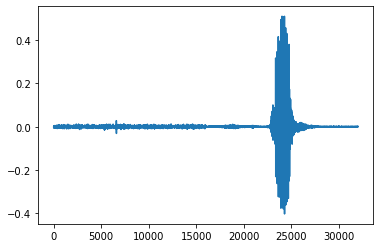

In [ ]:
testing_file0 = data['filename'][1200]
testing_file1 = data['filename'][400]
testing_sample = tf.concat([load_audio(testing_file0),
                            load_audio(testing_file1)], axis=0)


_ = plt.plot(testing_sample)

# Play the audio file.
display.Audio(testing_sample,rate=16000)

In [ ]:
def bounding_box(x):
    if tf.math.reduce_any(tf.math.abs(x)>0.25):
        left = max(0, int(tf.where(tf.math.abs(x)>0.25)[0]) - 2000)
        right = min(len(x), int(tf.where(tf.math.abs(x)>0.25)[-1]) + 4000)
    else:
        left = 0
        right = 0
    return np.array([left, right])

In [ ]:
bounding_box(long_silence)

array([0, 0])

## Generate longer samples

In [ ]:
silence_paths = np.array(data[data['category']=='_silence_']['filename'])

In [ ]:
long_silence = tf.zeros(shape=(0,), dtype='float32')
for path in silence_paths:
    long_silence = tf.concat([long_silence,
                              load_audio(path)/40], axis=0)

In [ ]:
long_silence[0]

<tf.Tensor: shape=(), dtype=float32, numpy=0.00043488876>

In [ ]:
bounding_box(long_silence)

[0, 0]

In [ ]:
data = data.drop(data[data['category']=='_silence_'].index)
data = data.drop(data[data['category']=='_unknown_'].index)
data = data.sample(frac = 1)
data.head()

,filename,label,category
463,./datasets/test_data/left/97f4c236_nohash_2.wav,1,left
3528,./datasets/test_data/go/85d2ac4b_nohash_0.wav,8,go
3838,./datasets/test_data/off/fb7eb481_nohash_3.wav,9,off
1600,./datasets/test_data/stop/893705bb_nohash_9.wav,3,stop
4190,./datasets/test_data/right/cfde27ba_nohash_0.wav,2,right


In [ ]:
lls = len(long_silence)
def audio_gen(paths, labels):
    # Concatinates audio files stored in paths adding
    # silence in between.
    s = len(paths) + 1
    s_loc = np.random.randint(lls - 8000)
    s_lens = sorted(list(np.random.randint(8000, size=s)), reverse=True)
    # Store the bounding boxes of the audio files.
    boxes = []
    s_len = s_lens.pop()
    x = long_silence[s_loc: s_loc+s_len]
    for filepath in paths:
        pointer = s_len
        y = load_audio(filepath)
        boxes.append(bounding_box(y) + len(x))
        x = tf.concat([x, y], axis=0)
        s_len = s_lens.pop()
        x = tf.concat([x, long_silence[s_loc+pointer: s_loc+s_len] ], axis=0)
    return [x, labels, boxes]

In [ ]:
x = audio_gen(data['filename'][0:3], data['label'][0:3])

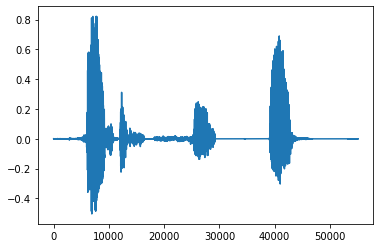

In [ ]:
_ = plt.plot(x[0])

# Play the audio file.
display.Audio(x[0],rate=16000)

In [ ]:
x[-1]

[array([ 4121, 16344]), array([23604, 31549]), array([37205, 46629])]

# Learning bounding boxes

In [ ]:
train_data = np.zeros(shape=(0,16000))
train_targets = np.zeros(shape=(0,2))
train_labels = np.zeros(shape=(0))
for index, sample in data.iterrows():
    x = load_audio(sample['filename'])
    train_data = np.concatenate([train_data, [x]], axis=0)
    train_targets = np.concatenate([train_targets, [bounding_box(x)]], axis=0)
    train_labels = np.concatenate([train_labels, [sample['label']]], axis=0)

In [ ]:
train_targets = train_targets.astype(int)

In [ ]:
train_data = train_data.reshape((-1,16000,1))

## Classifying frames

In [ ]:
def class_targets(targets):
    x = np.zeros(shape=(len(targets),16000))
    for i in range(len(targets)):
        x[i, targets[i, 0]:targets[i,1]] += 1
    return x

In [ ]:
target_boxes = class_targets(train_targets)

In [ ]:
inputs = keras.Input(shape=(16000,1))
x = layers.Conv1D(2, 64, strides=8, activation="relu", padding="same")(inputs)
#x = layers.Conv1D(16, 128, strides=10, activation="relu", padding="same")(x)

#x = layers.Conv1DTranspose(16, 128, strides=10, activation="relu", padding="same")(x)
x = layers.Conv1DTranspose(1, 64, strides=8, activation="relu", padding="same")(x)
x = layers.Conv1D(1, 3, activation="sigmoid", padding="same")(x)

model = keras.Model(inputs, x)
model.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 16000, 1)]        0         
                                                                 
 conv1d_37 (Conv1D)          (None, 2000, 2)           130       
                                                                 
 conv1d_transpose_21 (Conv1D  (None, 16000, 1)         129       
 Transpose)                                                      
                                                                 
 conv1d_38 (Conv1D)          (None, 16000, 1)          4         
                                                                 
Total params: 263
Trainable params: 263
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer="adam", loss="binary_crossentropy")
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                         patience=4,
                                         restore_best_weights=True)

In [ ]:
model.fit(train_data, target_boxes, validation_split=0.1, batch_size=16, epochs=20)

Epoch 1/20
230/230 [==============================] - 25s 105ms/step - loss: 0.6634 - val_loss: 0.6307
Epoch 2/20
230/230 [==============================] - 20s 86ms/step - loss: 0.6142 - val_loss: 0.5923
Epoch 3/20
230/230 [==============================] - 20s 86ms/step - loss: 0.5850 - val_loss: 0.5679
Epoch 4/20
230/230 [==============================] - 20s 86ms/step - loss: 0.5656 - val_loss: 0.5532
Epoch 5/20
230/230 [==============================] - 20s 86ms/step - loss: 0.5528 - val_loss: 0.5402
Epoch 6/20
230/230 [==============================] - 20s 85ms/step - loss: 0.5437 - val_loss: 0.5317
Epoch 7/20
230/230 [==============================] - 21s 90ms/step - loss: 0.5369 - val_loss: 0.5254
Epoch 8/20
230/230 [==============================] - 20s 85ms/step - loss: 0.5319 - val_loss: 0.5205
Epoch 9/20
230/230 [==============================] - 20s 86ms/step - loss: 0.5281 - val_loss: 0.5165
Epoch 10/20
230/230 [==============================] - 20s 85ms/step - loss: 0.52

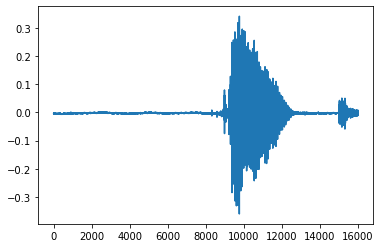

In [ ]:
test_sample = load_audio('/content/datasets/train_data/eight/004ae714_nohash_0.wav')
_ = plt.plot(test_sample)

# Play the audio file.
display.Audio(test_sample,rate=16000)

In [ ]:
predicted_box = model.predict(np.array(test_sample).reshape(1,16000,1))

In [ ]:
predicted_box

array([[[0.43589452],
        [0.20240611],
        [0.20743465],
        ...,
        [0.23270786],
        [0.2436631 ],
        [0.43421924]]], dtype=float32)

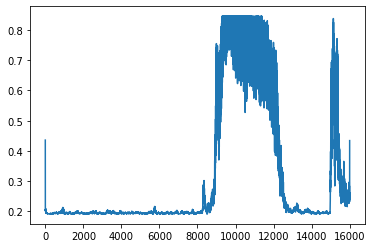

In [ ]:
_ = plt.plot(predicted_box.reshape(-1))

## Use a classifier